# First steps with sangria dataset

This notebook shows how to load the sangria data and have a first look using the LDC toolbox:
- Fourier transform
- Noise models and SNR computation
- fast waveform, waveform projection and TDI computation

## Software requirements

- `git clone https://gitlab.in2p3.fr/LISA/LDC`
- `pip install requirements.txt`
- `pip install git+https://gitlab.in2p3.fr/lisa-simulation/constants.git@master --no-binary :all:`
- `python setup.py build_liborbits install`

Look at the LDC README for more details. 

## Downloading the sangria dataset

- https://lisa-ldc.lal.in2p3.fr/
- https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_training_v2.h5

In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import ldc.io.hdf5 as hdfio
import xarray as xr # data with labels and coordinates
from astropy import units as u # data with units
import pandas as pd # jupyter views

## Loading the data

We use the LDC wrapper on xarray to manipulate time and frequency series

In [2]:
#!wget https://lisa-ldc.lal.in2p3.fr/media/uploads/LDC2_sangria_training_v2.h5

### Time series

In [3]:
from ldc.common.series import TimeSeries, FrequencySeries, TDI

sangria_fn = "LDC2_sangria_training_v2.h5"
tdi_ts = TDI.load(sangria_fn, name="obs/tdi")
dt = tdi_ts["X"].attrs["dt"]

In [4]:
print(tdi_ts)
print(tdi_ts.X.attrs)

<xarray.TDI>
Dimensions:  (t: 6307200)
Coordinates:
  * t        (t) float64 0.0 5.0 10.0 15.0 ... 3.154e+07 3.154e+07 3.154e+07
Data variables:
    X        (t) float64 -2.737e-21 3.341e-21 6.334e-21 ... -2.429e-20 9.921e-21
    Y        (t) float64 -3.261e-21 1.228e-20 1.268e-21 ... 1.978e-21 -5.733e-21
    Z        (t) float64 6.529e-22 -6.845e-21 8.661e-22 ... 2.715e-20 3.788e-21
{'units': None, 't0': 0.0, 'dt': 5.0}


- use labelled data to store TDI variables : `tdi.X` or `tdi["X"]` . `tdi.X.values`
- X, Y, Z share the same time coordinates: `tdi.t`
- units in attributes

### Go to frequency domain

We use a spectral window to remove samples at the edges. 

In [5]:
from ldc.common.tools import window

# Build frequencyseries object for X,Y,Z
tdi_fs = TDI(dict([(k,tdi_ts[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))

In [6]:
print(tdi_fs)
print(tdi_fs.X.attrs)

<xarray.TDI>
Dimensions:  (f: 3153601)
Coordinates:
  * f        (f) float64 0.0 3.171e-08 6.342e-08 9.513e-08 ... 0.1 0.1 0.1 0.1
Data variables:
    X        (f) complex128 (-1.6591974871462708e-13+0j) ... (-2.664627478753...
    Y        (f) complex128 (-4.060020028634799e-14+0j) ... (2.15612738874411...
    Z        (f) complex128 (2.0651994898938783e-13+0j) ... (6.42228463973767...
{'units': None, 'df': 3.1709791983764586e-08, 'kmin': 0, 't0': 0.0}


- one can switch from frequency to time domain with `tdi.X.ts.ifft()` and `tdi.X.ts.fft()`

## Looking at PSDs and building noise models

### Using a LISA predefined model

We provide a list of predefined noise model like "Proposal", "SciRDv1", "MRDv1", "sangria", "spritz", with analytic formula based on a given acceleration (low freq) and OMS (high freq) noise levels. 

In [7]:
from ldc.lisa.noise import get_noise_model

freq = np.logspace(-5, -1, 100) # some arbitrary freq range
noise_model = "sangria" 
Nmodel = get_noise_model(noise_model, freq)
Npsd = Nmodel.psd(option='X') # could be A, E, XY

In [8]:
? Nmodel.psd

#### Overplotting noise model and TDI X data

(1e-05, 0.16817928305074292, 4e-22, 2e-19)

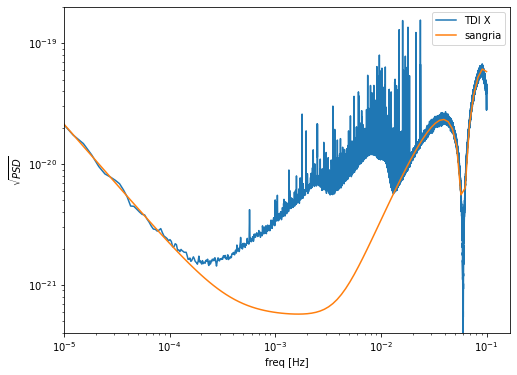

In [9]:
plt.figure(figsize=(8,6))
f, psdX =  scipy.signal.welch(tdi_ts["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX), label="TDI X")
plt.loglog(Nmodel.freq, np.sqrt(Npsd), label=noise_model)
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("$\sqrt{PSD}$")
plt.axis([1e-5, None, 4e-22, 2e-19])

Note that noise levels are different for the blind data set, such that one needs to fit them along with source signals. 

### Adding the white dwarfs residuals for a given number of years of observation

The toolbox provides analytical / idealized model for the white dwarf background, which can be used as a first guess, like shown below. However, we want to stress that this doesn't correspond to it's true value, which remains to be estimated from the data themselves. 

(1e-05, 0.15848931924611134, 4e-22, 2e-19)

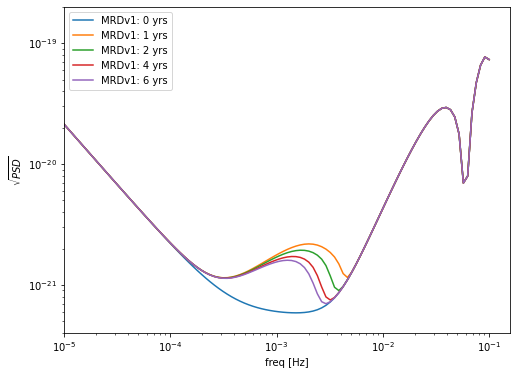

In [12]:
plt.figure(figsize=(8,6))
for yr in [0, 1, 2, 4, 6]:
    Nmodel = get_noise_model(noise_model, freq, wd=yr) # wd in years
    Npsd = Nmodel.psd()
    plt.loglog(Nmodel.freq, np.sqrt(Npsd), label=f'{Nmodel.model}: {yr} yrs')
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("$\sqrt{PSD}$")
plt.axis([1e-5, None, 4e-22, 2e-19])

## Waveforms

We introduce here:
- fast waveform which can be used to do the data analysis : source parameters $\rightarrow$ TDI in a fraction of s
- noise free time domain TDI generation: source parameters $\rightarrow$ h+,hx $\rightarrow$ y(t) $\rightarrow$ TDI in a dozen of s

The latter can be used to check the accuracy of fast waveforms, and is partly used to produce the simulated data (up to y(t), with LISANode performing the y(t) $\rightarrow$ TDI part). 

Those 2 ways of getting TDI from parameters are shown for: 
- Galactic binaries (GB)
- Massive black hole binaries (MBHB)

### Galactic binary parameters

There is 3 sets of galactic binaries in the dataset:
- 36 verification galactic binaries (vgb)
- ~3 millions of interacting galactic binaries (igb)
- ~26 millions of detached galactic binaries (dgb)

In [13]:
igb, units = hdfio.load_array(sangria_fn, name="sky/igb/cat")
pd.DataFrame(igb[0:10])

,Name,Amplitude,EclipticLatitude,EclipticLongitude,Frequency,FrequencyDerivative,Inclination,InitialPhase,Polarization
0,0,2.012287e-25,-0.195440,4.650345,0.000484,-4.209083e-22,2.039388,5.517622,5.093287
1,1,8.127227e-26,-0.712161,4.176887,0.000447,-3.537007e-22,1.831195,5.564847,5.370450
2,2,1.594158e-25,-0.012981,4.683487,0.000615,-1.431566e-21,1.540300,6.250097,0.415768
3,3,2.229746e-24,-0.935389,3.936696,0.001209,-6.520791e-20,2.114011,5.769329,3.404304
4,4,1.915065e-25,-0.158925,4.661912,0.000416,-2.446958e-22,2.339741,3.064232,2.962063
5,5,1.858429e-25,-0.506696,4.403089,0.000473,-4.172689e-22,0.732576,5.071122,0.734606
6,6,4.947628e-25,1.007436,5.955466,0.000484,-4.418931e-22,0.823482,5.892957,3.201665
7,7,1.904364e-25,-0.168753,4.612621,0.000454,-3.239163e-22,1.244329,1.603054,5.587253
8,8,1.890708e-25,-0.015785,4.681158,0.000370,-2.210984e-22,0.632128,4.028421,0.303602
9,9,1.487851e-25,-0.100450,4.573896,0.000443,-2.530930e-22,1.173299,4.199879,6.172673


#### Let's take one source from the detached binaries

In [14]:
one_source = np.array([(12401650, 1.35794643e-22, -0.51094868, 4.41775331, 
                 0.0102209, 1.32513112e-14, 
                 1.00784692, 3.18334868, 6.11709664)],
               dtype=[('Name', '<i8'), ('Amplitude', '<f8'), ('EclipticLatitude', '<f8'), ('EclipticLongitude', '<f8'), 
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'), 
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'), ('Polarization', '<f8')])

#### FastGB

The original `fastGB` is a python-interfaced C code. A small inconsistency between time domain and freq. domain waveforms has been discovered during the first round of sangria, leading to the development of a new pure python version of `fastGB`, which should be used to analyse the sangria data. 

This new pure python version is 1.5 x slower than the C version. 
We are planning to fix the C version as well. 

In [15]:
import ldc.waveform.fastGB as fastGB 
from ldc.lisa.orbits import Orbits

dt = tdi_ts["X"].attrs['dt']
tmax = tdi_ts["X"].t[-1]+dt # df is 1/tmax or 1/len(tdi.X)

orbits = Orbits.type(dict({'orbit_type':'analytic', 'nominal_arm_length':2.5e9, # or cfg["nominal_arm_length"]
                           "initial_position": 0, "initial_rotation": 0}))

GB = fastGB.FastGB(delta_t=dt, T=tmax, orbits=orbits)
pGB = dict(zip(one_source.dtype.names, one_source[0])) 
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4)

In [16]:
print(Xs)

<xarray.DataArray 'X' (f: 1024)>
array([-2.67902879e-19-7.62504456e-20j, -2.67739175e-19-7.70318815e-20j,
       -2.67575754e-19-7.78137232e-20j, ...,
       -2.68395711e-19-7.39084232e-20j, -2.68231144e-19-7.46887315e-20j,
       -2.68066867e-19-7.54694006e-20j])
Coordinates:
  * f        (f) float64 0.0102 0.0102 0.0102 0.0102 ... 0.01024 0.01024 0.01024
Attributes:
    units:    None
    df:       3.1709791983764586e-08
    kmin:     321814
    t0:       0


- X, Y, Z are small frequency series around source frequency
- Time domain TDI can be recovered by `GB.get_td_tdixyz`

#### Overplotting data and single source signal in Fourier domain

Text(0.5, 0, 'freq [Hz]')

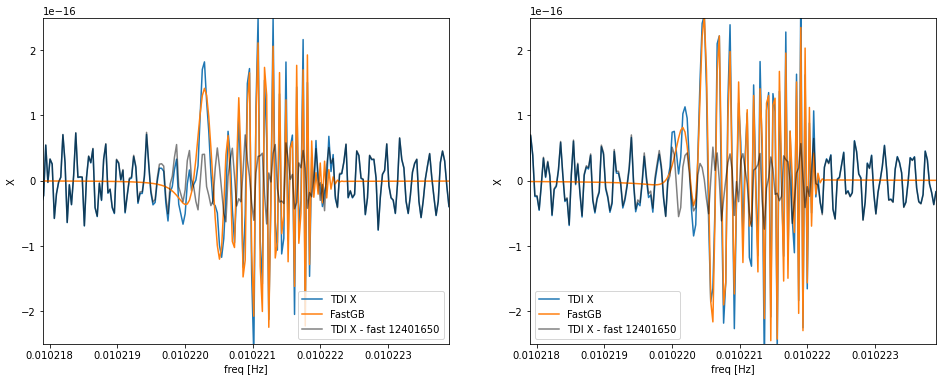

In [17]:
tdi_subset = tdi_fs.sel(f=Xs.f, method='nearest') # match freq range
## an alternative is X_subset = tdi_fs.X[int(Xs.attrs['kmin']):]

plt.figure(figsize=(16,6))

plt.subplot(121)
plt.title("real part")
tdi_fs["X"].real.plot(label="TDI X")
Xs.real.plot(label="FastGB")
plt.plot(Xs.f, tdi_subset["X"].values.real-Xs.real, label="TDI X - fast "+str(pGB["Name"]), alpha=0.5, color='k')
plt.axis([pGB["Frequency"]-3e-6, pGB["Frequency"]+3e-6, -2.5e-16, 2.5e-16])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")

plt.subplot(122)
plt.title("imaginary part")
tdi_fs["X"].imag.plot(label="TDI X")
Xs.imag.plot(label="FastGB")
plt.plot(Xs.f, tdi_subset["X"].values.imag-Xs.imag, label="TDI X - fast "+str(pGB["Name"]), alpha=0.5, color='k')
plt.axis([pGB["Frequency"]-3e-6, pGB["Frequency"]+3e-6, -2.5e-16, 2.5e-16])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

#### Overplotting noise free data and single source signal

For each component, we provide noise free TDI in the training data set: 'sky/dgb/tdi', 'sky/igb/tdi', 'sky/vgb/tdi', 'sky/mbhb/tdi'. They are produced exactly as the noisy data, just with all noise sources disabled in LISANode.  

In [18]:
tdi_nf = TDI.load(sangria_fn, name="sky/dgb/tdi")
tdi_nf = TDI(dict([(k,tdi_nf[k].ts.fft(win=window)) for k in ["X", "Y", "Z"]]))
tdi_subset = tdi_nf.sel(f=Xs.f, method='nearest') # match freq range

Text(0.5, 0, 'freq [Hz]')

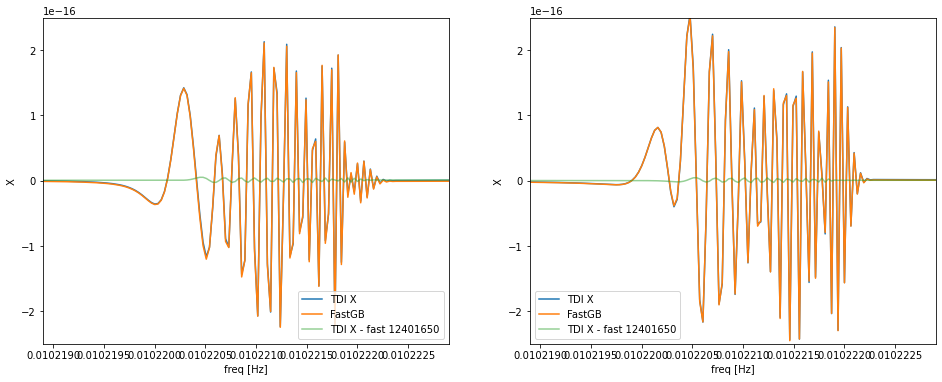

In [19]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("real part")
tdi_nf.X.real.plot(label="TDI X")
Xs.real.plot(label="FastGB")
plt.plot(Xs.f, tdi_subset["X"].values.real-Xs.real, label="TDI X - fast "+str(pGB["Name"]), alpha=0.5)
plt.axis([pGB["Frequency"]-2e-6, pGB["Frequency"]+2e-6, -2.5e-16, 2.5e-16])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")

plt.subplot(122)
plt.title("imaginary part")
tdi_nf.X.imag.plot(label="TDI X")
Xs.imag.plot(label="FastGB")
plt.plot(Xs.f, tdi_subset["X"].values.imag-Xs.imag, label="TDI X - fast "+str(pGB["Name"]), alpha=0.5)
plt.axis([pGB["Frequency"]-2e-6, pGB["Frequency"]+2e-6, -2.5e-16, 2.5e-16])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

#### Time domain TDI through h+,hx and projected strains

In [20]:
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain

## h+, hx
GW = HpHc.type("debug", "GB", "TD_fdot")
GW.set_param(pGB)

## y(t)
p = ProjectedStrain(orbits)
yArm = p.arm_response(0, tmax, dt, [GW])
print(p.links)
p.to_file("my_input_file_to_lisanode.h5")

['1-2', '1-3', '2-1', '2-3', '3-1', '3-2']


Projected strains y(t) are given as input to LISANode in the simulation pipeline. But one can produce TDI from them, using the LDC, to get single source, noise free TDI, as shown below. 

In [21]:
## TDI in time domain
tdi_x = TimeSeries(p.compute_tdi_x(np.arange(0, tmax, dt)), dt=dt, t0=0)

## TDI in freq domain
tdi_x = tdi_x.ts.fft(win=window)
tdi_x = tdi_x.sel(f=Xs.f, method="nearest")

#### Overplotting time domain single source noise free TDI and fastGB

Text(0.5, 0, 'freq [Hz]')

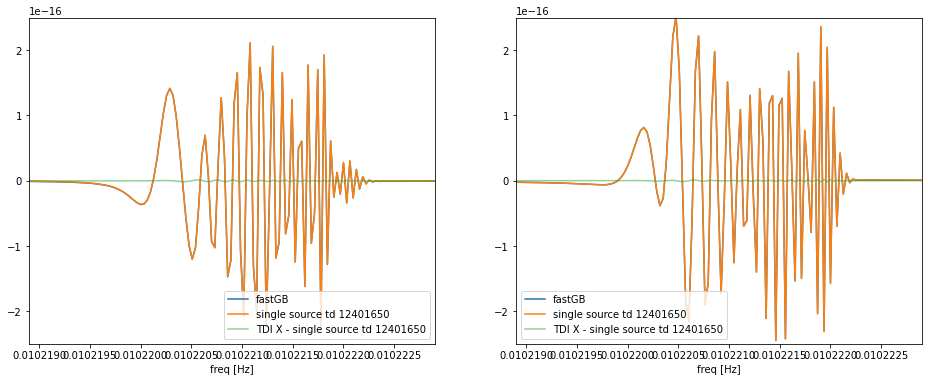

In [22]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("real part")
Xs.real.plot(label='fastGB')
tdi_x.real.plot(label="single source td "+str(pGB["Name"]))
plt.plot(Xs.f, Xs.real-tdi_x.values.real, label="TDI X - single source td "+str(pGB["Name"]), alpha=0.5)
plt.axis([pGB["Frequency"]-2e-6, pGB["Frequency"]+2e-6, -2.5e-16, 2.5e-16])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")

plt.subplot(122)
plt.title("imaginary part")
Xs.imag.plot(label='fastGB')
tdi_x.imag.plot(label="single source td "+str(pGB["Name"]))
plt.plot(Xs.f, Xs.imag-tdi_x.imag, label="TDI X - single source td "+str(pGB["Name"]), alpha=0.5)
plt.axis([pGB["Frequency"]-2e-6, pGB["Frequency"]+2e-6, -2.5e-16, 2.5e-16])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

#### Computing the SNR of verification binaries

With waveform and noise model in hands, one can get source SNR. Below, we show how to compute the SNR of the 36 verification binaries. 

\begin{equation}
\mathrm{SNR}^2 = 4 \Re \int_{f_{min}}^{f_{max}} \frac{\tilde{X}(f) \tilde{X}(f)^{*}}{S_{n}(f)}df
\end{equation}

In [23]:
from ldc.common.tools import compute_tdi_snr

vgb, units = hdfio.load_array(sangria_fn, name="sky/vgb/cat")
GB = fastGB.FastGB(delta_t=dt, T=tmax.values) # in seconds

noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))

SNR = np.zeros((len(vgb))) # snr square
for j,s in enumerate(vgb):
    pGB = dict(zip(vgb.dtype.names, s))
    Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4)
    tdi = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR[j] = np.sqrt(compute_tdi_snr(tdi, Nmodel)["tot2"]) #expected SNR

In [24]:
data = np.array([vgb["Name"], vgb["Frequency"], SNR]).T
pd.DataFrame(data, columns=["Name", "f0", "fastGB"])

,Name,f0,fastGB
0,HPLib,0.0018137299356125872,75.39980564772812
1,ZTFJ2320,0.0006033546882680517,0.4542232694840151
2,SDSSJ0923,0.0005149728351829441,5.584528867497056
3,AMCVn,0.0019441447221331155,128.30411990888464
4,CX1751,0.0014545454545454545,8.449472978953732
5,ZTFJ2029,0.0015973720048555093,6.631014332170485
6,SDSSJ0935,0.0016835016835016834,78.66336628740069
7,ZTFJ1539,0.004821699107149872,62.68462058094589
8,SDSSJ2322,0.0016647244880972198,37.09646403828031
9,4U1820-30,0.0029196570097891864,9.703851952877717


- Using option `full_output`, one can get the cumulative SNR as a function of frequency 
- noise can be a Noise instance or an arbitrary TDI frequency series with noise PSD.
- Use option `AET=True' to compute SNR in quasi orthogonal TDI variables

In [25]:
SNR = compute_tdi_snr(tdi, Nmodel, full_output=True) #expected SNR
print(list(SNR.keys()))

['X2', 'Y2', 'Z2', 'tot2', 'cumsum', 'freq', 'EXX', 'EXY']


Text(0.5, 0, 'freq [Hz]')

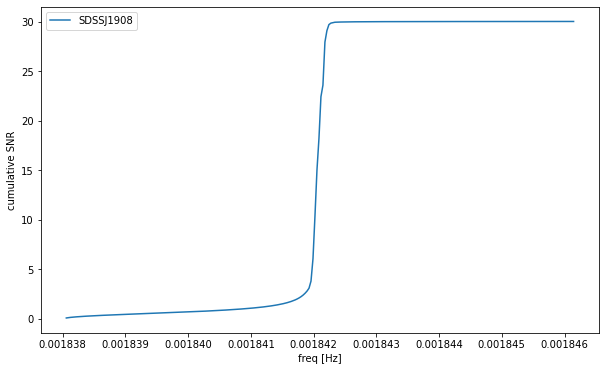

In [26]:
plt.figure(figsize=(10,6))
plt.plot(SNR['freq'], np.sqrt(SNR['cumsum']), label=s['Name'])
plt.legend()
plt.ylabel("cumulative SNR")
plt.xlabel("freq [Hz]")

### Massive black holes binaries waveforms

One needs to install `lisabeta` to get a fast MBHB waveform generator interfaced with the LDC toolbox.

See https://github.com/SylvainMarsat/lisabeta for installation instructions. 

In [27]:
import ldc.io.hdf5 as hdfio
mbhb, units = hdfio.load_array(sangria_fn, name="sky/mbhb/cat")
pd.DataFrame(mbhb)

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance,ObservationDuration,Cadence
0,-0.564102,0.610927,0.908972,1.181699,0.972661,0.972862,1.015522e+06,7.968491e+05,4.800021e+06,4.275929,2.577539,4.094550,2.18186,17758.367941,3.155815e+07,3.0
1,-1.081082,4.052963,2.354232,1.689765,0.742128,0.989247,4.956676e+06,4.067167e+06,8.746488e+06,3.783309,0.963586,3.636925,6.17688,61097.116076,3.155815e+07,3.0
2,0.636028,0.779159,2.332027,2.065443,0.574122,0.592671,1.773563e+06,1.083356e+06,1.116784e+07,2.311127,0.232802,3.798411,6.03496,59472.237592,3.155815e+07,3.0
3,-0.878570,4.549720,2.068669,1.097989,0.942824,0.870789,9.159926e+05,7.017527e+05,1.125857e+07,1.150360,1.899782,5.829771,1.10396,7705.852640,3.155815e+07,3.0
4,-0.303004,1.292518,1.203136,2.097304,0.747377,0.838800,1.323277e+06,6.124855e+05,1.152694e+07,1.220197,2.691982,1.808398,1.73941,13470.983559,3.155815e+07,3.0
5,0.147296,5.986230,2.434152,1.926613,0.745574,0.546848,2.830218e+06,2.322253e+06,1.197096e+07,4.111379,1.131250,4.319761,5.50770,53474.693790,3.155815e+07,3.0
6,-0.987304,3.886726,2.594339,1.719446,0.829141,0.972219,3.204750e+06,3.056613e+06,1.361711e+07,3.628682,2.050928,1.084370,2.87966,24829.137775,3.155815e+07,3.0
7,0.917031,3.584892,1.665850,2.092903,0.988778,0.975945,1.856420e+06,1.801541e+06,1.653219e+07,1.866057,1.410068,0.527915,4.57261,43010.925050,3.155815e+07,3.0
8,0.835250,3.257316,2.362671,1.539846,0.833674,0.981901,3.983915e+06,2.049535e+06,1.724516e+07,1.578620,2.323179,3.643228,3.34910,29747.551597,3.155815e+07,3.0
9,-0.521369,3.085541,2.582941,2.200156,0.825883,0.811360,3.128823e+06,2.640346e+06,1.860576e+07,3.425317,2.604701,1.670016,7.21026,73048.167218,3.155815e+07,3.0


#### Fast MBH

In [28]:
from ldc.waveform.lisabeta import FastBHB

s_index = 0 # Look at 1st source
pMBHB = dict(zip(mbhb.dtype.names, mbhb[s_index]))

FBH = FastBHB("MBHB", T=tmax.values, delta_t=dt, approx="IMRPhenomD", orbits=orbits)

A,E,T = FBH.get_td_tdiaet(template=pMBHB)
XYZ = TDI(dict(zip(["A", "E", "T"], [A, E, T])))
XYZ.AET2XYZ()

The `TDI` class provides TDI variables transfomation, like `AET2XZY()` and `XYZ2AET()`: 
$E = \frac{X - 2Y + Z}{\sqrt{6}}$ $A = \frac{Z - X}{\sqrt{2}}$ $T = \frac{X + Y + Z}{\sqrt{3}}$ 

#### Overplotting data and fast approximant

Text(0.5, 0, 'time [s]')

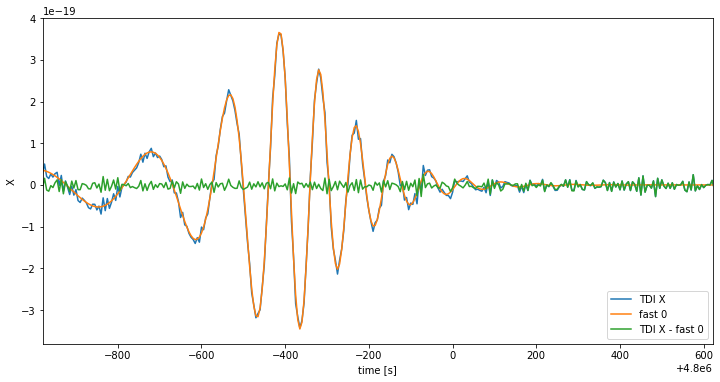

In [29]:
plt.figure(figsize=(12,6))
plt.plot(tdi_ts["X"].t, tdi_ts["X"], label="TDI X")
XYZ.X.plot(label="fast %d"%s_index)
plt.plot(XYZ.t, tdi_ts["X"]-XYZ.X, label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-1000, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

#### Overplotting noise free data and fast approximant

In [30]:
tdi_nf = TDI.load(sangria_fn, name="sky/mbhb/tdi")

Text(0.5, 0, 'time [s]')

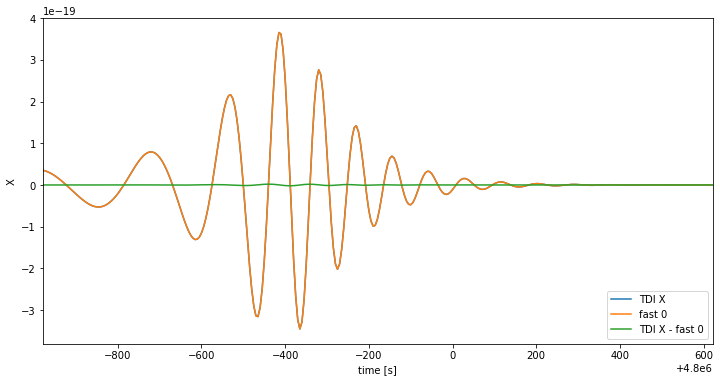

In [31]:
plt.figure(figsize=(12,6))
plt.plot(tdi_nf["X"].t, tdi_nf["X"], label="TDI X")
XYZ.X.plot(label="fast %d"%s_index)
plt.plot(XYZ.t, tdi_nf["X"]-XYZ.X, label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-1000, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

#### Time domain TDI through h+,hx and projected strains

In [32]:
def time_domain_tdi(config, pMBHB, t_max, dt):
    """ Project h+,hx on LISA arm and compute TDI with time domain interpolation. 
    """
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    if config["orbit_type"]=='equal_armlength':
        config["orbit_type"] = 'analytic'
    orbits = Orbits.type(config)    
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=config['travel_time_order'])
    X = P.compute_tdi_x(np.arange(0, t_max, dt))
    return TimeSeries(X, dt=dt)

config = hdfio.load_config(sangria_fn, name="obs/config")
Xs = time_domain_tdi(config, pMBHB, tmax, dt)

#### Overplotting single source noise free and fast MBH

Text(0.5, 0, 'time [s]')

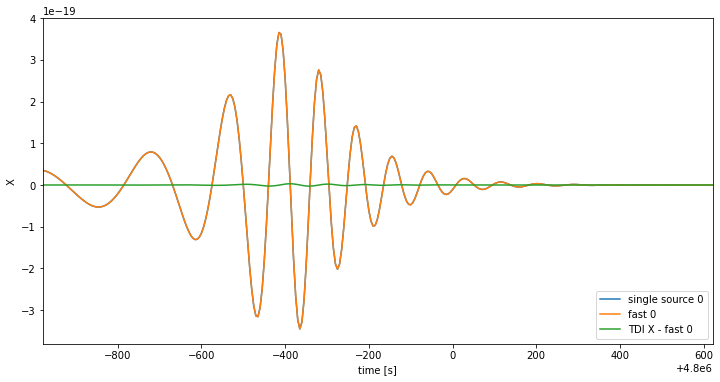

In [33]:
plt.figure(figsize=(12,6))
Xs.plot(label="single source %d"%s_index)
XYZ.X.plot(label="fast %d"%s_index)
plt.plot(Xs.t, (XYZ.X-Xs), label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-1000, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

## Looking at simulation parameters

In [34]:
config = hdfio.load_config(sangria_fn, name="obs/config")
config

{'accnoise': 2.4e-15,
 'backlinknoise': 3e-12,
 'dirname': 'v2',
 'dt': <Quantity 2.5 s>,
 'dt_instrument': <Quantity 0.25 s>,
 'dt_orbits': <Quantity 86400. s>,
 'dt_tdi': <Quantity 5. s>,
 'initial_position': <Quantity 0. rad>,
 'initial_rotation': <Quantity 0. rad>,
 'interp_order': 9,
 'nbatch': 1,
 'nominal_arm_length': <Quantity 2.5e+09 m>,
 'orbit_type': 'equal_armlength',
 'physic_upsampling': 1,
 'readoutnoise': 6.35e-12,
 'sim_kaiser_attenuation': 240,
 'sim_kaiser_delay': 4.5,
 'sim_kaiser_passband': 1.1,
 'sim_kaiser_stopband': 2.9,
 't_max': <Quantity 31536000. s>,
 't_min': <Quantity 0. s>,
 'tdi_kaiser_attenuation': 240,
 'tdi_kaiser_cutoff': 0.05,
 'tdi_kaiser_delay': 161.75,
 'tdi_kaiser_passband': 0.05,
 'tdi_kaiser_stopband': 0.1,
 'travel_time_order': 1}

# Looking at source parameters

In [35]:
config = hdfio.load_config(sangria_fn, name="sky/mbhb/config")
config

{'approximant': 'IMRPhenomD',
 'catalogs': '/data/Q3d_complete',
 'coalescence_time_0': 0.1,
 'coalescence_time_1': 0.95,
 'indices_0': 185,
 'indices_1': 469,
 'indices_10': 134,
 'indices_11': 383,
 'indices_12': 117,
 'indices_13': 258,
 'indices_14': 204,
 'indices_2': 640,
 'indices_3': 547,
 'indices_4': 671,
 'indices_5': 340,
 'indices_6': 267,
 'indices_7': 58,
 'indices_8': 301,
 'indices_9': 488,
 'mass_ratio_0': 1,
 'mass_ratio_1': 10,
 'mass_total_0': -1,
 'mass_total_1': 5000,
 'nsource': 15,
 'seed': 1234,
 'source_type': 'MBHB',
 'spin1_0': 0.5,
 'spin1_1': 0.99,
 'spin2_0': 0.5,
 'spin2_1': 0.99}

# Looking at LISANode configuration

In [36]:
config = hdfio.load_config(sangria_fn, name="instru/config")
config

{'LISA_AAFILTER_ATTENUATION': 240,
 'LISA_AAFILTER_TRANSITION_BAND_0': 1.1,
 'LISA_AAFILTER_TRANSITION_BAND_1': 2.9,
 'LISA_ACC_NOISE_A_LEVEL': 2.4e-15,
 'LISA_ACC_NOISE_F_KNEE': 0.0004,
 'LISA_ACC_NOISE_USE_PZM': False,
 'LISA_ADC_RECURSION_ORDER': 1,
 'LISA_BACKLINK_NOISE_A_LEVEL': 3e-12,
 'LISA_BACKLINK_NOISE_F_KNEE': 0.002,
 'LISA_DEBUG_CLOCK_OFFSETS': False,
 'LISA_FREQUENCY_OFFSETS_12': 8.1,
 'LISA_FREQUENCY_OFFSETS_13': 1.4,
 'LISA_FREQUENCY_OFFSETS_21': -9.5,
 'LISA_FREQUENCY_OFFSETS_23': 9.2,
 'LISA_FREQUENCY_OFFSETS_31': 10.3,
 'LISA_FREQUENCY_OFFSETS_32': -11.6,
 'LISA_GLITCH_FILE': 'None',
 'LISA_GW_FILE_FS': 0.4,
 'LISA_GW_FILE_UPSAMPLING': 10.0,
 'LISA_GW_TYPE': 'file',
 'LISA_LASER_CENTRAL_FREQUENCY': 281600000.0,
 'LISA_LOCKING_SCHEME': 'N1c',
 'LISA_MEASUREMENT_DOWNSAMPLING': 1,
 'LISA_MEASUREMENT_FS': 4.0,
 'LISA_ORBIT_TYPE_0': 'file',
 'LISA_ORBIT_TYPE_1': 'ppr',
 'LISA_PHYSICS_FS': 4.0,
 'LISA_PRIMARY_LASER': '12',
 'LISA_PUBLISH_BEATNOTE_COMPONENTS': True,
 'LISA_P